In [1]:
import numpy as np


In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage

In [3]:
import gzip
import pickle

with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    train_set,test_set = pickle.load(f)

In [4]:
train_x, train_y = train_set
test_x,test_y=test_set

In [5]:
x_train = train_x
x_test = test_x


In [6]:
#preprocessing
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


In [7]:
x_train[0].shape

(28, 28, 1)

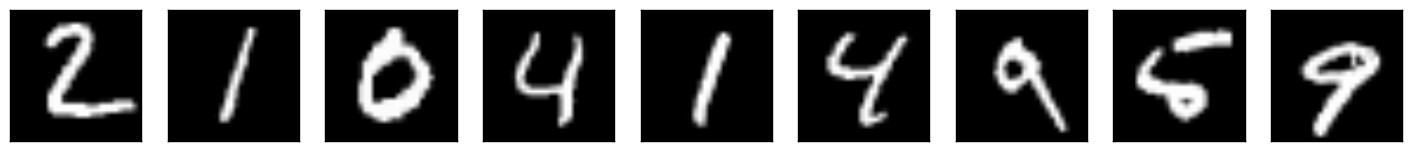

In [8]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
#adding noise
def salt_and_pepper(x_train,x_test,factor):
    noise_factor = factor
    
    x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [10]:
def gaussian_noise(x_train,x_test,sigma):
    row,col,ch= x_train[0].shape
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    x_test_noisy = skimage.util.random_noise(x_test, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    
    
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [11]:
x_train_noisy,x_test_noisy = salt_and_pepper(x_train,x_test,0.5)

In [82]:
x_train_noisy,x_test_noisy = gaussian_noise(x_train,x_test,0.5)

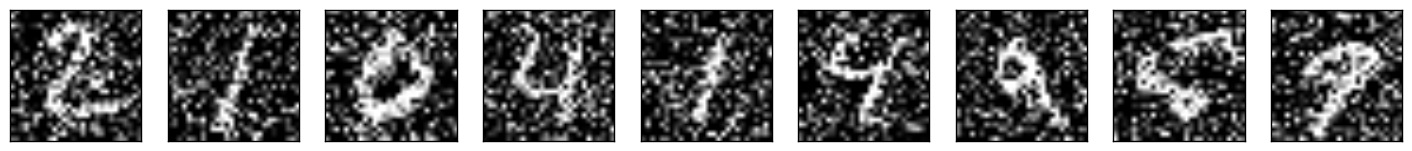

In [83]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [84]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard


In [85]:
input_img = Input(shape=x_train[0].shape)  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

print autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [86]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 185s - loss: 0.2067 - val_loss: 0.1348


In [87]:
out = autoencoder.predict(x_test_noisy,verbose=1)

 9952/10000 [============================>.] - ETA: 0s

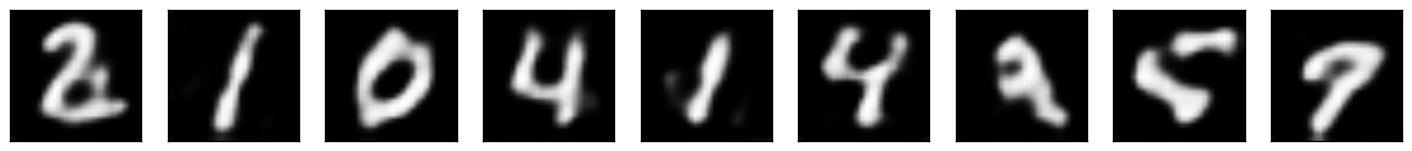

In [88]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(out[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
import cv2

In [139]:
test_image = cv2.imread('data/two',0)


In [140]:
test_image = cv2.resize(test_image,(28,28))
test_image = np.expand_dims(test_image, axis=2)
gd= test_image
gd/=255

In [58]:
test_image = skimage.util.random_noise(test_image, mode='gaussian', seed=None, clip=True, mean=0, var=0.5**0.5)

In [141]:
test_image ,test_image1= salt_and_pepper(test_image,test_image,0.5)

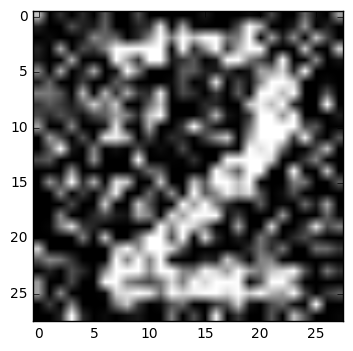

In [153]:
plt.imshow(test_image.reshape(28,28))
plt.show()

In [143]:
test=np.empty([1,28,28,1])
test[0]=test_image
pred = autoencoder.predict(test,verbose=1)

1/1 [==============================] - 0s


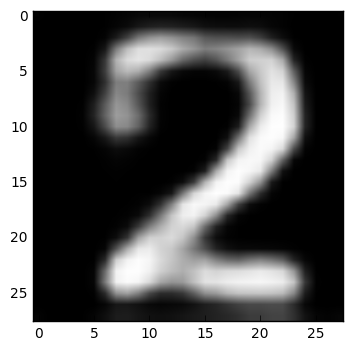

In [170]:
plt.imshow(pred.reshape(28,28))
plt.show()
pred = pred.reshape(28,28,1)

In [177]:
import math
def get_mse(imageA,imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [178]:
get_mse(test_image,pred)

0.11093865985434821

In [179]:
def get_psnr(imageA,imageB):
    maxI = 1
    try:
        return 20*math.log10(maxI) - 10*math.log10(get_mse(imageA,imageB))
    except:
        return 20*math.log10(maxI)

In [180]:
print get_psnr(pred,test_image)

9.54917084729


In [181]:
print get_mse(pred,gd)
print get_mse(test_image,gd)
print get_mse(test_image,pred)

0.0448768498622
0.122651485151
0.110938659854


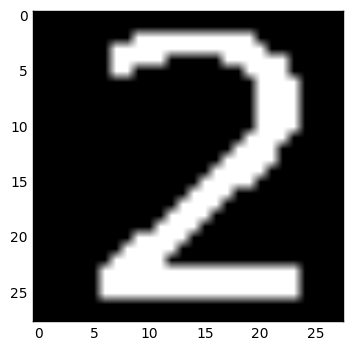

In [182]:
plt.imshow(gd.reshape(28,28))
plt.show()

In [183]:
print get_psnr(pred,gd)
print get_psnr(test_image,gd)
print get_psnr(test_image,pred)

13.4797763605
9.11327188682
9.54917084729
